# Dian24春招TEST1

In [1]:
import torch
from IPython import display
from d2l import torch as d2l
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision
from torchvision import transforms
from d2l import torch as d2l
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from torchvision import datasets, transforms


## 数据加载

In [2]:
def get_dataloader_workers():
    
    return 4
#加载MNIST里的数据
def load_data_mnist(batch_size, resize=None):
    """Download the MNIST dataset and then load it into memory.

    Defined in :numref:`sec_utils`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.MNIST(
        root="../data", train=False, transform=trans, download=True)
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                        num_workers=get_dataloader_workers()),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                        num_workers=get_dataloader_workers()))
batch_size = 256
train_iter, test_iter =load_data_mnist(batch_size)
print(train_iter,test_iter)

<torch.utils.data.dataloader.DataLoader object at 0x00000245651CD580> <torch.utils.data.dataloader.DataLoader object at 0x000002456525F670>


## 搭建全连接网络

In [3]:
#搭建题目所要求的全连接网络
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(nn.Flatten(),
            nn.Linear(28*28, 128),  # 第一层，将28x28的图片展平后输入，输出128个节点
            nn.ReLU(),
            nn.Linear(128, 256),  # 第二层，接收第一层的128个节点，输出256个节点
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.Softmax(dim=1)
            ) # 最后一层，输出10个节点，对应10个类别)
    def forward(self,x):
        output=self.net(x)
        return output
net=MLP()
print(net)

MLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
    (6): Softmax(dim=1)
  )
)


## 初始化权重

In [4]:
#采用Xavier法初始化权重
def init_normal(m):
    if type(m)==nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
net.apply(init_normal)
#print(net.net[1].weight.data[0])
print(net.net[1].bias.data[0])

tensor(0.)


## 定义损失函数

In [5]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

## 计算准确率

In [6]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [7]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [8]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [9]:
evaluate_accuracy(net, test_iter)

0.1688

## 在一个周期内训练模型

In [10]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

## 添加动态可视化

In [11]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

## 训练模型可视化&评价标准可视化

In [12]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): 
    animator1 = Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=[0.0, 1.0],
                        legend=['Accuracy', 'Precision', 'Recall','F1score'])
    accuracy_total, precision_total, recall_total, f1_total =compute_metrics_show(net,test_iter,loss)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        if epoch==0:
            animator1.add(epoch, (accuracy_total,)+(precision_total,)+(recall_total,)+(f1_total,))
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        num=0
        for X, y in test_iter:
            pred = net(X)
            pred = torch.argmax(pred, dim=1)
            accuracy, precision_mean, recall_mean, f1_mean = compute_metrics(pred, y, num_classes=10)
            accuracy_total += accuracy
            precision_total += precision_mean
            recall_total += recall_mean
            f1_total += f1_mean
            num+=1
        print(num)
        accuracy_total /= num
        precision_total /= num
        recall_total /= num
        f1_total/=num
        animator1.add(epoch + 1, (accuracy_total,)+(precision_total,)+(recall_total,)+(f1_total,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
    '''最后三个 assert 语句的作用是用来在训练过程中进行模型性能的检查和验证。
    这些断言语句确保模型的训练和测试表现符合预期的标准。如果这些断言未能通过，
    程序将抛出 AssertionError，并显示相关的值。'''
    

In [13]:
def compute_metrics(preds, labels, num_classes):
    # 初始化混淆矩阵
    confusion_matrix = torch.zeros(num_classes, num_classes)
    for p, l in zip(preds, labels):
        confusion_matrix[l, p] += 1
        
    # 计算每个类的精确率和召回率
    precision = torch.diag(confusion_matrix) / confusion_matrix.sum(0)
    recall = torch.diag(confusion_matrix) / confusion_matrix.sum(1)

    # 计算F1-Score
    f1 = 2 * precision * recall / (precision + recall)

    # 计算总的准确率
    accuracy = torch.diag(confusion_matrix).sum() / confusion_matrix.sum()

    # 因为可能存在分母为0的情况，我们需要处理NaN值
    precision[precision != precision] = 0  # 将NaN替换为0
    recall[recall != recall] = 0
    f1[f1 != f1] = 0

    # 计算平均值
    precision_mean = precision.mean().item()
    recall_mean = recall.mean().item()
    f1_mean = f1.mean().item()

    return accuracy.item(), precision_mean, recall_mean, f1_mean

In [14]:
def compute_metrics_show(net,test_iter,loss): 
    epochs = 10
    accuracy_total, precision_total, recall_total, f1_total = 0, 0, 0, 0
    with torch.no_grad():
        for epoch in range(epochs):
            num=0
            for X, y in test_iter:
                pred = net(X)
                pred = torch.argmax(pred, dim=1)
                accuracy, precision_mean, recall_mean, f1_mean = compute_metrics(pred, y, num_classes=10)
                accuracy_total += accuracy
                precision_total += precision_mean
                recall_total += recall_mean
                f1_total += f1_mean
                num+=1
            accuracy_total /= num
            precision_total /= num
            recall_total /= num
            f1_total/=num
    return accuracy_total,precision_total,recall_total,f1_total

In [15]:
lr = 0.1
optimizer = torch.optim.SGD(net.parameters(),lr=lr)

## 获取对应的标签

In [16]:
def get_mnist_labels(labels):
    """Return text labels for the Fashion-MNIST dataset.

    Defined in :numref:`sec_utils`"""
    text_labels = ['0', '1', '2', '3', '4',
                   '5', '6', '7', '8', '9']
    return [text_labels[int(i)] for i in labels]

## 训练前模型的表现

(0.17658253205128202,
 0.1323742654461127,
 0.18001382186626774,
 0.11573118353501344)

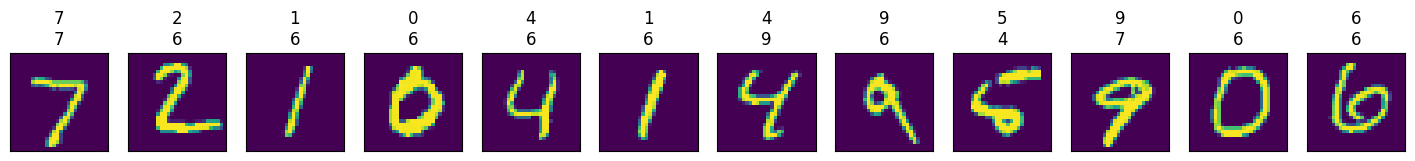

In [17]:
def predict_ch3(net,test_iter,n=12):
    for X,y in test_iter:
        break
    #只从数据迭代器中获取一个批次的数据
    trues=get_mnist_labels(y)
    preds=get_mnist_labels(net(X).argmax(axis=1))
    accuracy, precision_mean, recall_mean, f1_mean =compute_metrics(y,net(X).argmax(axis=1),10)
    titles=[true+'\n'+pred for true,pred in zip(trues,preds)]
    d2l.show_images(X[0:n].reshape((n,28,28)),1,n,titles=titles[0:n])
    
predict_ch3(net,test_iter)
compute_metrics_show(net,test_iter,cross_entropy)


## 训练后模型的表现

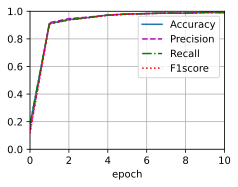

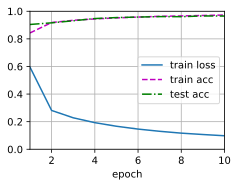

In [21]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, optimizer)

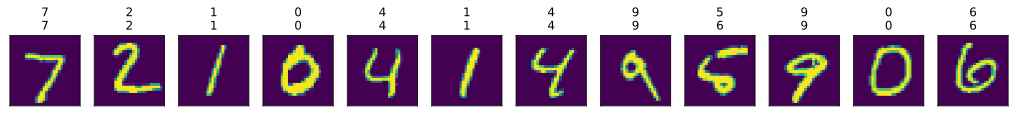

In [22]:
predict_ch3(net,test_iter)

In [23]:
compute_metrics_show(net,test_iter,cross_entropy)

(0.9908854166666666,
 0.9909245417668269,
 0.9910260347219613,
 0.9898582528799007)

## 探索层数，神经元个数以及训练步数对模型表现的影响

In [36]:
#通过更改神经网络的内部层数来探究变化
class MLP1(nn.Module):
    def __init__(self):  
        super().__init__()
        self.net=nn.Sequential(nn.Flatten(),
            nn.Linear(28*28, 128),  # 第一层，将28x28的图片展平后输入，输出128个节点
            nn.ReLU(),
            nn.Linear(128, 128),  # 第二层，将28x28的图片展平后输入，输出128个节点
            nn.ReLU(),
            nn.Linear(128, 128),  # 第三层，将28x28的图片展平后输入，输出128个节点
            nn.ReLU(),
            nn.Linear(128, 128),  # 第四层，将28x28的图片展平后输入，输出128个节点
            nn.ReLU(),
            nn.Linear(128, 256),  # 第五层，接收第一层的128个节点，输出256个节点
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.Softmax(dim=1)
            ) # 最后一层，输出10个节点，对应10个类别)
    def forward(self,x):
        output=self.net(x)
        return output
net1=MLP1()
print(net1)

MLP1(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=256, bias=True)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=10, bias=True)
    (12): Softmax(dim=1)
  )
)


In [37]:
#采用Xavier法初始化权重
def init_normal(m):
    if type(m)==nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
net1.apply(init_normal)
#print(net.net[1].weight.data[0])
print(net1.net[1].bias.data[0])

tensor(0.)


In [38]:
evaluate_accuracy(net1, test_iter)

0.1145

(0.11768830128205128,
 0.0508081500346844,
 0.10970315451805406,
 0.050601109289205984)

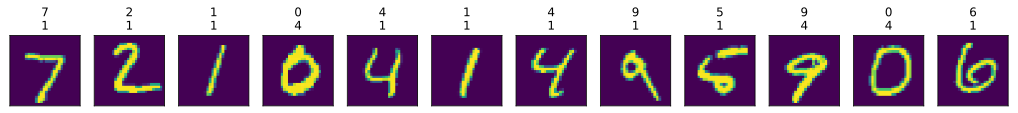

In [39]:
predict_ch3(net1,test_iter)
compute_metrics_show(net1,test_iter,cross_entropy)

In [40]:
lr = 0.1
optimizer = torch.optim.SGD(net1.parameters(),lr=lr)

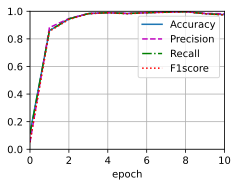

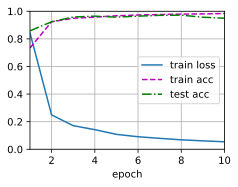

In [41]:
num_epochs = 10
train_ch3(net1, train_iter, test_iter, cross_entropy, num_epochs, optimizer)

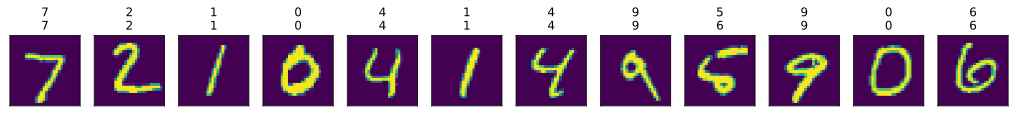

In [49]:
predict_ch3(net1,test_iter)

In [42]:
#通过更改神经网络的内部神经元来探究变化
class MLP2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(nn.Flatten(),
            nn.Linear(28*28, 64),  # 第一层，将28x28的图片展平后输入，输出128个节点
            nn.ReLU(),
            nn.Linear(64, 128),  # 第二层，接收第一层的128个节点，输出256个节点
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
            ) # 最后一层，输出10个节点，对应10个类别)
    def forward(self,x):
        output=self.net(x)
        return output
net2=MLP2()
print(net2)

MLP2(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
    (6): Softmax(dim=1)
  )
)


In [43]:
#采用Xavier法初始化权重
def init_normal(m):
    if type(m)==nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
net2.apply(init_normal)
#print(net.net[1].weight.data[0])
print(net2.net[1].bias.data[0])

tensor(0.)


In [44]:
evaluate_accuracy(net2, test_iter)

0.1005

(0.10366586538461538,
 0.053039710204570725,
 0.10682459080066435,
 0.043078004072109856)

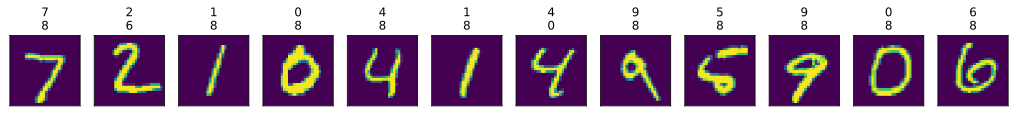

In [46]:
predict_ch3(net2,test_iter)
compute_metrics_show(net2,test_iter,cross_entropy)

In [47]:
lr = 0.1
optimizer = torch.optim.SGD(net2.parameters(),lr=lr)

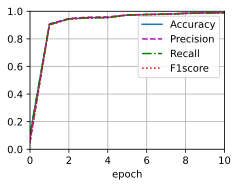

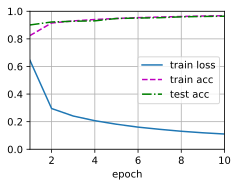

In [48]:
num_epochs = 10
train_ch3(net2, train_iter, test_iter, cross_entropy, num_epochs, optimizer)

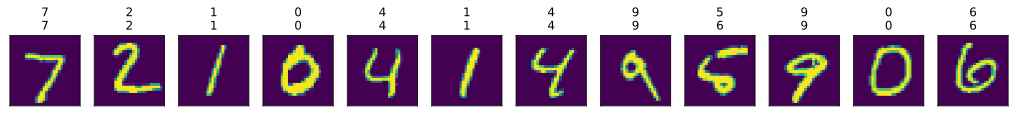

In [50]:
predict_ch3(net2,test_iter)

## 探究超参数对模型的影响

### K折交叉检验

In [51]:
def train_multiple(net, train_iter, test_iter, loss, num_epochs, updater): 
    animator = Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=[0.0, 1.0],
                        legend=['F1score'])
    accuracy_total, precision_total, recall_total, f1_total =compute_metrics_show(net,test_iter,loss)
    for epoch in range(num_epochs):
        if epoch==0:
            animator1.add(epoch,(f1_total,))
        train_epoch_ch3(net, train_iter, loss, updater)
        num=0
        for X, y in test_iter:
            pred = net(X)
            pred = torch.argmax(pred, dim=1)
            accuracy, precision_mean, recall_mean, f1_mean = compute_metrics(pred, y, num_classes=10)
            f1_total += f1_mean
            num+=1
        print(num)
        f1_total/=num
        animator1.add(epoch + 1,(f1_total,))

In [52]:
# 定义训练过程
def train_model(model, train_loader, optimizer, criterion, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

# 定义测试过程
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

In [53]:
def k_fold_cross_validation(k, model_class, dataset, batch_size, learning_rate, num_epochs=5):
    kf = KFold(n_splits=k, shuffle=True)
    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
        print(f'Fold {fold+1}/{k}')
        
        # 创建数据加载器
        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
        
        # 初始化模型、优化器和损失函数
        model = model_class()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        
        # 训练模型
        train_model(model, train_loader, optimizer, criterion, num_epochs)
        
        # 测试模型
        test_loss, accuracy = test_model(model, test_loader, criterion)
        print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
        
        fold_results.append((test_loss, accuracy))
    
    return fold_results


Fold 5: Loss = 0.0241, Accuracy = 92.56%
Average Loss: 0.0245, Average Accuracy: 90.50%


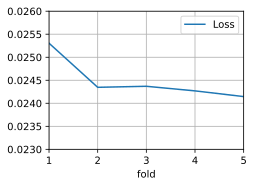

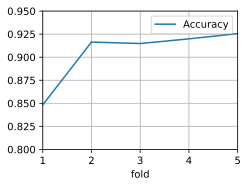

In [54]:
# 加载MNIST数据集
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST('.', download=True, train=True, transform=transform)

#初始化超参数
batch_size, learning_rate, num_epochs, k = 64, 0.1, 5, 5
    
# 执行K折交叉验证
results = k_fold_cross_validation(k, MLP, dataset, batch_size, learning_rate, num_epochs)

animator1 = Animator(xlabel='fold', xlim=[1, 5], ylim=[0.023, 0.026],legend=['Loss'])
animator2 = Animator(xlabel='fold', xlim=[1, 5], ylim=[0.8, 0.95],legend=['Accuracy'])
    
# 打印每折的结果
for fold, (test_loss, accuracy) in enumerate(results, 1):
    animator1.add(fold,(test_loss,))
    animator2.add(fold,(accuracy/100,))
    print(f'Fold {fold}: Loss = {test_loss:.4f}, Accuracy = {accuracy:.2f}%')

# 计算平均性能
avg_loss = sum(x[0] for x in results) / k
avg_accuracy = sum(x[1] for x in results) / k
print(f'Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.2f}%')